# Setup

from google.colab import drive
drive.mount('/content/drive')

In [1]:
# !pip install pydrive

The following part is to interact with the Drive (authentication, download or upload data...):

In [61]:
import zipfile
from os import listdir
import glob
import os
import sys

import numpy as np
from scipy.io import wavfile
from scipy import signal
import librosa
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import pandas as pd

import tensorflow as tf

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Reshape, GRU
from keras.regularizers import l2

from sklearn.model_selection import train_test_split

import h5py

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")



In [62]:
# Plot parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'

# Loading data from drive

We need to have uploaded the file on the Drive and right click to create a shareable link. The id can be found at the end of the url. This id must be used in the following cells (replacing the one I used from my Drive).

In [63]:
print(os.listdir('../input'))


['bird_data.h5', 'ff1010bird_metadata.csv', 'ff1010bird_wav.zip', 'model_bird.h5', 'warblrb10k_public_metadata.csv', 'warblrb10k_public_wav.zip', 'wav']


In [64]:
"""
os.chdir('../input')

zip_ref = zipfile.ZipFile("ff1010bird_wav.zip", 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile("warblrb10k_public_wav.zip", 'r')
zip_ref.extractall()
zip_ref.close()
os.chdir('../notebook')
print(' unzip files, done')
"""

'\nos.chdir(\'../input\')\n\nzip_ref = zipfile.ZipFile("ff1010bird_wav.zip", \'r\')\nzip_ref.extractall()\nzip_ref.close()\n\nzip_ref = zipfile.ZipFile("warblrb10k_public_wav.zip", \'r\')\nzip_ref.extractall()\nzip_ref.close()\nos.chdir(\'../notebook\')\nprint(\' unzip files, done\')\n'

In [65]:
all_path = listdir('../input/wav')
all_path = ['../input/wav/' + x for x in all_path]

In [66]:
len(all_path)

15690

## Load labels

In [67]:
#y1 = pd.read_csv('/content/drive/My Drive/ff1010bird_metadata.csv')
#y2 = pd.read_csv('/content/drive/My Drive/warblrb10k_public_metadata.csv')
y1 = pd.read_csv('../input/ff1010bird_metadata.csv')
y2 = pd.read_csv('../input/warblrb10k_public_metadata.csv')

y_df = pd.concat([y1, y2])
y_df['itemid'] = y_df['itemid'].astype(str)
y = y_df.sort_values('itemid')['hasbird'].values

# Audio preprocessing

In [68]:
def load_wav(pathList, num, decimate=None):
    """
        Load audio data.

        Parameters
        ----------
        pathList : list
            List of wav file paths.
        num : int
            What file to choose among the list of path.
        decimate : int
            If not None, downsampling by a factor of `decimate` value.

        Returns:
        -------
        S : array-like
            Array of shape (Mel bands, time) containing the spectrogram.
    """
    # Load data
    fs, data = wavfile.read(pathList[num])

    data = data.astype(np.float32)

    if decimate is not None:
        data = signal.decimate(data, decimate)
        fs /= decimate

    return fs, data


def create_spec(data, fs, n_mels = 32, n_fft = 2048, hop_len = 1024):
    """
        Compute the Mel spectrogram from audio data.

        Parameters
        ----------
        data : array-like
            Audio data.
        fs : int
            Sampling frequency in Hz.
        n_mels : int
            Number of Mel bands to generate.
        n_fft : int
            Length of the FFT window.
        hop_len : int
            Number of samples between successive frames.

        Returns:
        -------
        S : array-like
            Array of shape (Mel bands, time) containing the spectrogram.
    """
    # Calculate spectrogram
    S = librosa.feature.melspectrogram(
      data, sr=fs, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)
    S = S.astype(np.float32)

    # Convert power to dB
#     S = np.log(S * 10 + 0.001)
    S = librosa.power_to_db(S)

    return S
  
def plot_spec(S):
    """
        Plot a spectrogram.

        Parameters
        ----------
        S : array-like
            Spectrogram.
    """
    plt.figure()
    plt.imshow(S, cmap=plt.get_cmap('inferno'), aspect='auto', origin='lower')
    plt.axis('off')
    plt.show()
    plt.close()

In [69]:
all_path.sort()

In [103]:
seed = 123
X_train, X_test, y_train, y_test = train_test_split(all_path, y, test_size=0.35, random_state=seed)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5)

num_train_obs = len(X_train)
num_test_obs = len(X_test)
num_validation_obs = len(X_validation)

print('X_train', len(X_train), 'y_train', len(y_train))
print('X_test', len(X_test), 'y_test', len(y_test))
print('X_validation', len(X_validation), 'y_validation', len(y_validation))


X_train 10198 y_train 10198
X_test 2746 y_test 2746
X_validation 2746 y_validation 2746


## Test labels: check labels

In [104]:
print(len(X_train))

10198


In [105]:
position = 3 #'../input/wav/f052c1d4-f05b-44b6-864d.wav'
nb_err = 0

for i in range(len(X_train)):
    fname = X_train[i].split('/')[position].split('.')[0]
    lab = y_train[i]

    true_lab = y_df['hasbird'][y_df["itemid"] == fname].values[0]
    if lab != true_lab:
        print('error', fname)
        nb_err = nb_err + 1

for i in range(len(X_test)):
    fname = X_test[i].split('/')[position].split('.')[0]
    lab = y_test[i]

    true_lab = y_df['hasbird'][y_df["itemid"] == fname].values[0]
    if lab != true_lab:
        print('error', fname)
        nb_err = nb_err + 1
        
if nb_err == 0:
    print('-check ok')


-check ok


### Sound examples

In [106]:

#fs, data = load_wav(['./wav/19257.wav'], 0)
fs, data = load_wav(['../input/wav/19257.wav'], 0)
print(type(fs),type(data))

<class 'int'> <class 'numpy.ndarray'>


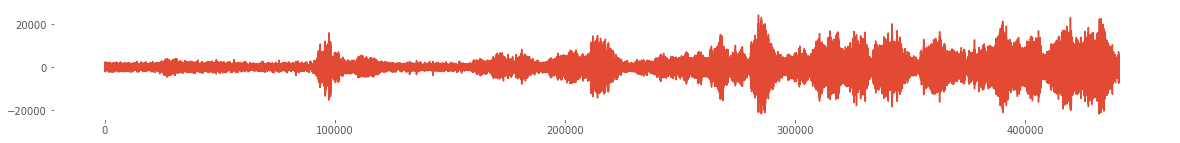

In [107]:
plt.plot(data)

## Creating MEL spectrograms

In [108]:
fs = 44100
# From Cakir
N_MELS = 40

# MEL spec from STFT 40 ms and 20 ms overlap
N_FFT = int(0.04 * fs) + 1
HOP_LEN = int(0.02 * fs) + 1

In [109]:
S = create_spec(data[:(44100 * 10)], fs, n_mels = N_MELS, n_fft = N_FFT, hop_len = HOP_LEN)
print(type(S), S.shape)

<class 'numpy.ndarray'> (40, 500)


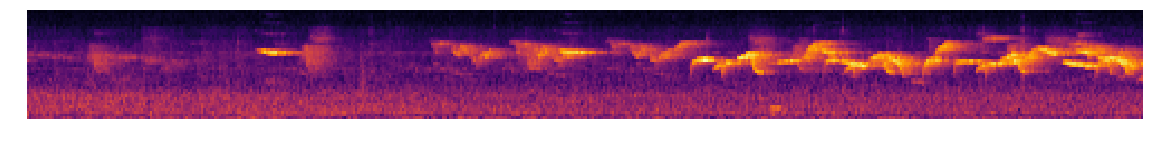

In [110]:
pylab.rcParams['figure.figsize'] = (20, 2)

plot_spec(S)

In [111]:
S.shape

(40, 500)

In [112]:

import IPython.display as ipd
ipd.Audio('../input/wav/19257.wav')
#ipd.Audio('./wav/19257.wav')

#### Augmentation
https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

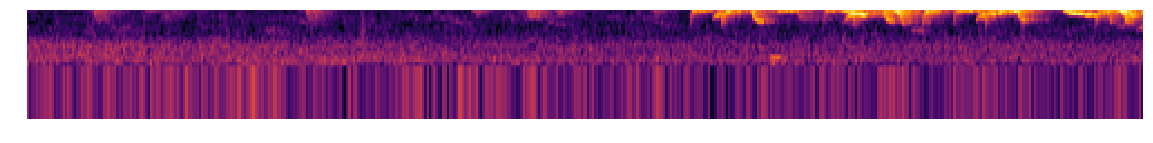

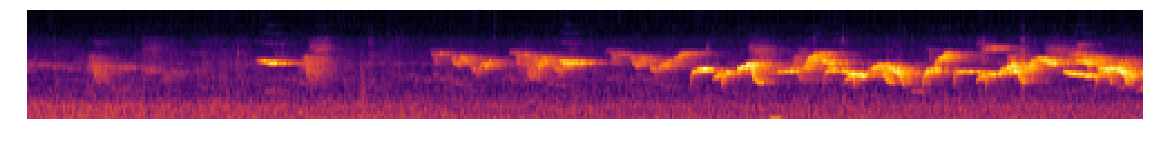

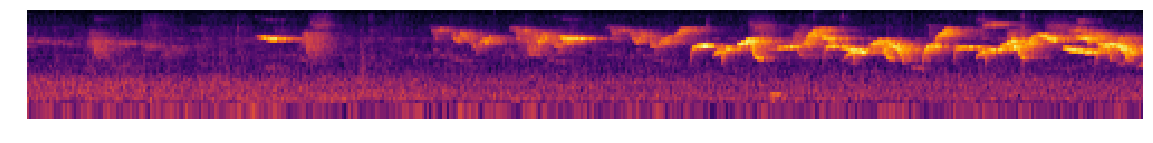

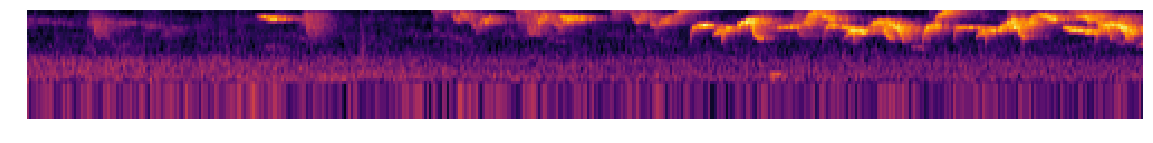

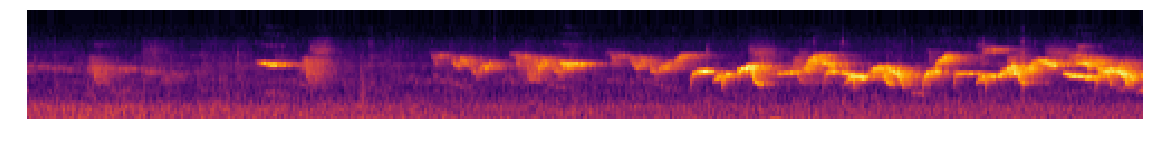

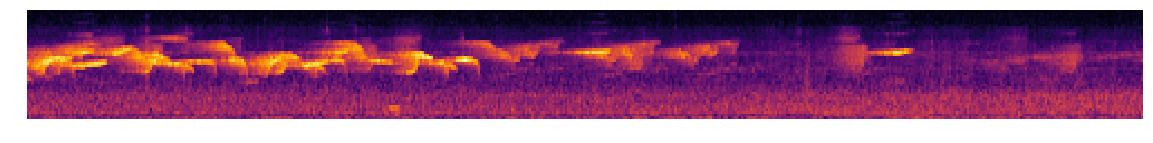

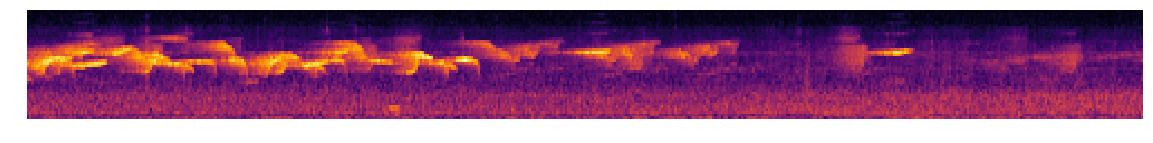

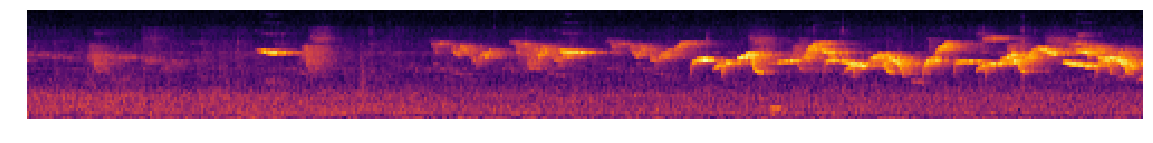

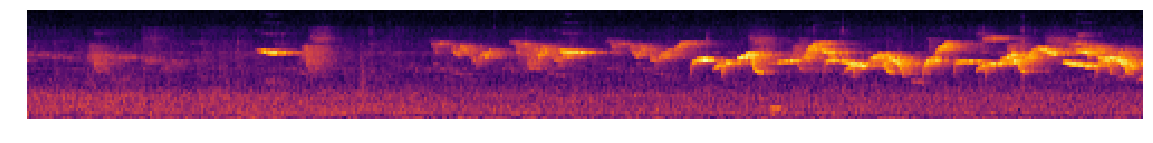

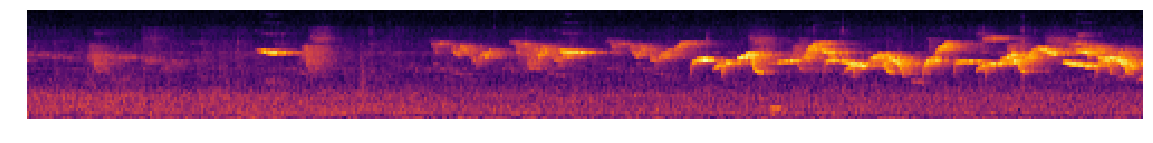

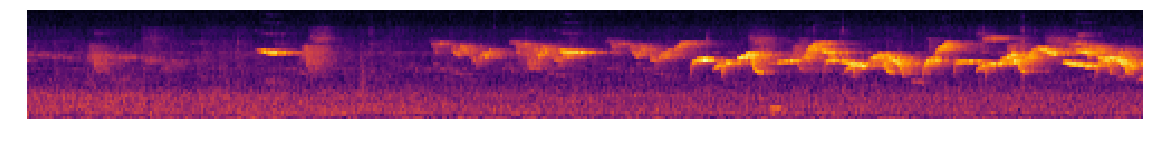

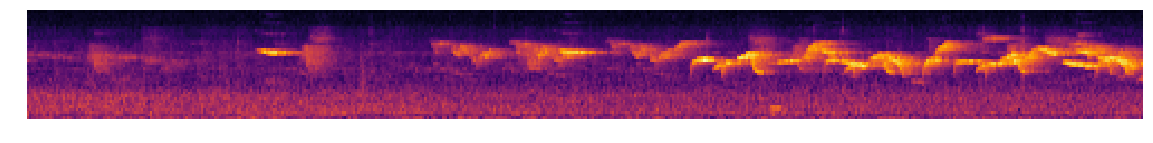

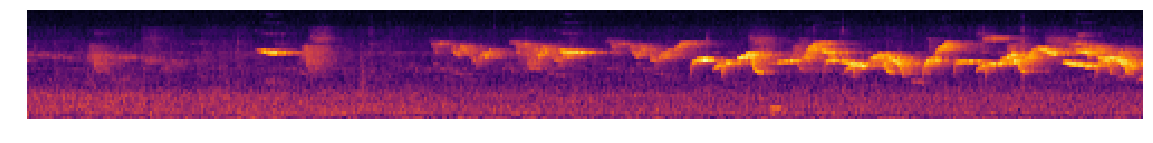

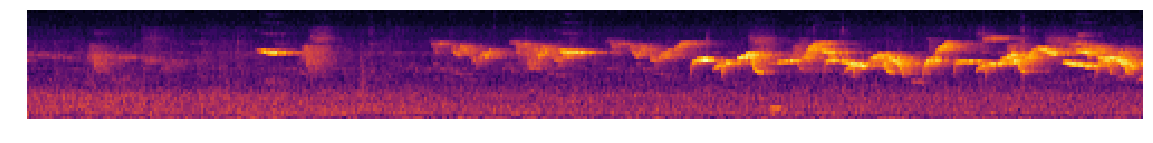

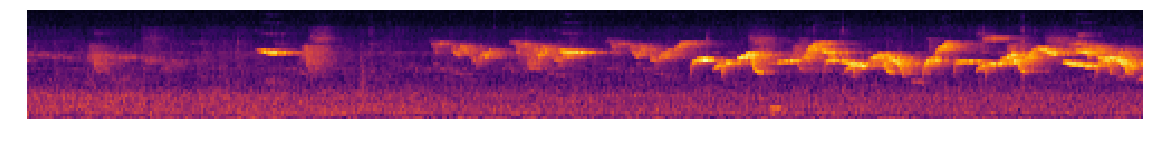

--> 15 images


In [113]:
datagen_width_shift = ImageDataGenerator(width_shift_range=[-30,30])
datagen_height_shift = ImageDataGenerator(height_shift_range=0.5)
datagen_horizontal_flip = ImageDataGenerator(horizontal_flip=True)
datagen_brightness = ImageDataGenerator(brightness_range=[0.2,1.0])
datagen_list = [datagen_height_shift, datagen_horizontal_flip, datagen_brightness]

def datagen_augmentation(datagen, S, my_range=5):
    list_S = []
    # load the image
    #img = load_img('bird.jpg')
    # convert to numpy array
    #data = img_to_array(img)
    #print(S.shape)
    data = np.expand_dims(S, axis=2) 
    #print(data.shape)
    
    # expand dimension to one sample
    samples = expand_dims(data, 0) 
    # create image data augmentation generator
    #datagen = ImageDataGenerator(horizontal_flip=True)
    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(my_range):
        # define subplot
        #pyplot.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        image = image[:,:,0]
        list_S.append(image)
        # plot raw pixel data
        #pyplot.imshow(image)
        plot_spec(image)
    # show the figure
    return list_S

list_S = []
for x in datagen_list:
    list_S = list_S + datagen_augmentation(x, S)
print('-->',len(list_S), 'images')    
    


In [114]:
def create_list_spec(list_audio, fs, n_mels, hop_len):
    """
        Compute the spectrogram of each chunk from a list of audio data.

        Parameters
        ----------
        list_audio : list
            List of audio data.
        fs : int
            Sampling frequency in Hz.

        Returns:
        -------
        list_spec : list
            List of spectrograms.
    """
    list_spec = []
    count = 0
    for audio in list_audio:
        S = create_spec(audio, fs, n_mels = n_mels, hop_len = hop_len)
        list_spec.append(S)
        count += 1
        
    return list_spec


def create_dataset(paths_wav, n_mels, hop_len, dur=False):
    
    all_spec = []
    all_audio = []

    for i in range(len(paths_wav)):
        fs, data = load_wav(paths_wav, i)
        if (dur and ((data.shape[0] / fs) > dur)):
            # cut audio
            data = data[:fs * dur]
        elif (dur and ((data.shape[0] / fs) < dur)):
            # pad audio
            pad_len = (fs * dur) - data.shape[0]
            data = np.pad(data, (0, pad_len), 'constant')
        
        all_audio.append(data)
        
    list_spec = create_list_spec(all_audio, fs, n_mels, hop_len)

    all_spec += list_spec
    
    # stack list of spectrograms in one 3d array
    X = np.array(all_spec)
    
    return X

In [115]:
X = create_dataset(paths_wav = all_path[:2000], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [116]:
X.shape

(2000, 40, 500)

In [117]:
X1 = create_dataset(paths_wav = all_path[2000:4000], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [118]:
X2 = create_dataset(paths_wav = all_path[4000:6000], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [119]:
X3 = create_dataset(paths_wav = all_path[6000:8000], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [120]:
X4 = create_dataset(paths_wav = all_path[8000:10000], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [121]:
X5 = create_dataset(paths_wav = all_path[10000:12000], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [122]:
X6 = create_dataset(paths_wav = all_path[12000:14000], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [123]:
X7 = create_dataset(paths_wav = all_path[14000:], n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)

In [124]:

X_all = np.concatenate([X, X1, X2, X3, X4, X5, X6, X7], axis=0)
print('X_all.shape',X_all.shape,'y.shape',y.shape)


X_all.shape (15690, 40, 500) y.shape (15690,)


In [125]:
#h5f = h5py.File('/content/drive/My Drive/bird_data.h5', 'w')
h5f = h5py.File('../input/bird_data.h5', 'w')
h5f.create_dataset('X_all', data=X_all)
h5f.close()

In [126]:
#h5f = h5py.File('/content/drive/My Drive/bird_data.h5', 'r')
h5f = h5py.File('../input/bird_data.h5', 'r')
X_all = h5f['X_all'][:]
h5f.close()

In [127]:
X_all.shape

(15690, 40, 500)

# Model

Use area under the curve as training metric.

In [128]:
import tensorflow as tf
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

The model is from https://www.eurasip.org/Proceedings/Eusipco/Eusipco2017/papers/1570342815.pdf

In [129]:
y.shape



(15690,)

In [130]:
from keras.utils import Sequence

class My_Generator(Sequence):

    def __init__(self, sound_filenames, labels, batch_size):
        print('init')
        self.sound_filenames = sound_filenames
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sound_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        print('getitem', idx)
        batch_x = self.sound_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x_data = create_dataset(paths_wav = batch_x, n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)
        batch_x_data = batch_x_data.reshape((batch_x_data.shape[0], batch_x_data.shape[1], batch_x_data.shape[2], 1))

        return batch_x_data, np.array(batch_y)


In [131]:
batch_size = 64

train_gen = My_Generator(X_train, y_train, batch_size)
test_gen = My_Generator(X_test, y_test, batch_size)

validation_gen = My_Generator(X_validation, y_validation, batch_size)


init
init
init


In [132]:

# def data_gen(X, y, batch_size):
#     count = 0
#     while True:
#         new_X = []
#         new_y = []
#         for i in range(batch_size):
#             if count + i < len(X):
#                 new_X.append(X[count + i])
#                 new_y.append(y[count + i])
      
#         count += batch_size
#         print(' count, ', count)
#         X_data = create_dataset(paths_wav = new_X, n_mels = N_MELS, hop_len = HOP_LEN, dur = 10)
#         X_data = X_data.reshape((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
#         yield (X_data, np.array(new_y))
    
# data_gen(X_train, y_train, batch_size=2)


# def csv_image_generator(inputPath, bs):
#     # open the CSV file for reading
#     f = open(inputPath, "r")

#     # loop indefinitely
#     while True:
#         # initialize our batches of images and labels
#         images = []
#         labels = []
    
#         # keep looping until we reach our batch size
#         while len(images) < bs:
#             # attempt to read the next line of the CSV file
#             line = f.readline()
#             print(line)
    
#             # check to see if the line is empty, indicating we have
#             # reached the end of the file
#             if line == "":
#                 # reset the file pointer to the beginning of the file
#                 # and re-read the line
#                 f.seek(0)
#                 line = f.readline()
            
#             # update our corresponding batches lists
#             images.append(line[0])
#             labels.append(line[1])
            
#         # yield the batch to the calling function
#         print(images, labels)
#     yield (images, labels)




    

#  list(csv_image_generator('ff1010bird_metadata.csv', bs=2))


In [133]:
class My_Callback(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.uploaded = drive.CreateFile({'title': 'model_bird.h5'})
        
#         return

    def on_batch_end(self, batch, logs={}):
        print('batch', batch)        
        self.model.save('../input/model_bird.h5')
        #self.model.save('/content/drive/My Drive/model_bird.h5')


#         self.uploaded.SetContentFile('model_bird.h5')
#         self.uploaded.Upload()
        
        return
      
my_callback = My_Callback()

In [ ]:
def train():
    """
    global X_all, y #CM
    
    # Split dataset for training and testing
    seed = 123
    X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2,
                                                        random_state=seed)
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
    """
    input_shape = (40, 500, 1)
    
    print(input_shape)
    
    inputs = Input(name='input', shape=input_shape, dtype='float32')
    
    print(inputs.shape)
    
    model = Conv2D(96, (5, 5), padding='same', name='conv1', activation='relu')(inputs) # (None, 40, 500, 96)
    model = BatchNormalization()(model)
    model = Dropout(0.25)(model)
    model = MaxPooling2D(pool_size=(5, 1), name='max1')(model) # (None, 8, 500, 96)
    
    print(model.shape)
    
    model = Conv2D(96, (5, 5), padding='same', name='conv2', activation='relu')(model) # (None, 8, 500, 96)
    model = BatchNormalization()(model)
    model = Dropout(0.25)(model)
    model = MaxPooling2D(pool_size=(2, 1), name='max2')(model) # (None, 4, 500, 96)
    
    print(model.shape)
    
    model = Conv2D(96, (5, 5), padding='same', name='conv3', activation='relu')(model) # (None, 4, 500, 96)
    model = BatchNormalization()(model)
    model = Dropout(0.25)(model)
    model = MaxPooling2D(pool_size=(2, 1), name='max3')(model) # (None, 2, 500, 96)
    
    print(model.shape)
    
    model = Conv2D(96, (5, 5), padding='same', name='conv4', activation='relu')(model) # (None, 2, 500, 96)
    model = BatchNormalization()(model)
    model = Dropout(0.25)(model)
    model = MaxPooling2D(pool_size=(2, 1), name='max4')(model) # (None, 1, 500, 96)
    
    print(model.shape)
    
    model = Reshape((500, 96))(model)
    
    print('after reshape', model.shape)
    
    model = GRU(units=96, activation="tanh", return_sequences=True, input_shape=(500, 96))(model) # (96, 500)
    
    print(model.shape)
    
    model = Dropout(0.25)(model)
    model = GRU(activation="tanh", return_sequences=True, units=96, input_shape=(500, 96))(model) # (96, 500)
    
    print('after first gru', model.shape)
    
    model = Reshape((1, 500, 96))(model)
    
    print(model.shape)
    
    model = MaxPooling2D(pool_size=(500, 1), name='max5', data_format='channels_first')(model) # (96, 1)
    
    print(model.shape)
    
    model = Reshape((96,))(model)
    
    print(model.shape)
    
    model = Dense(1, activation='sigmoid')(model)
    
    print(model.shape)
    
    model = Model(inputs=inputs, outputs=model)
    model.summary()
  

    # initiate RMSprop optimizer
    opt = keras.optimizers.adam(lr=0.01)

    # Let's train the model
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=[auc, 'accuracy'])

    history = model.fit_generator(
        train_gen,
        steps_per_epoch=num_train_obs // batch_size,
        validation_data=test_gen,
        validation_steps=num_test_obs // batch_size,
        epochs=5,
        callbacks=[my_callback],
        verbose=True,
    )

    # summarize history for accuracy
    plt.figure()

    plt.plot(history.history['acc'], label='acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_los')

    plt.ylabel('loss or acc')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc', 'loss', 'val_loss'], loc='upper left')

    plt.show()
    plt.close()

    return model, history

model, history = train()

(40, 500, 1)
(?, 40, 500, 1)
(?, 8, 500, 96)
(?, 4, 500, 96)
(?, 2, 500, 96)
(?, 1, 500, 96)
after reshape (?, 500, 96)
(?, ?, 96)
after first gru (?, ?, 96)
(?, 1, 500, 96)
(?, 1, 1, 96)
(?, 96)
(?, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40, 500, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 500, 96)       2496      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 500, 96)       384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 500, 96)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 8, 500, 96)        0         
_________________________________________________________________
conv2

105/159 [==================>...........] - ETA: 27:31 - loss: 0.5675 - auc: 0.7292 - acc: 0.7100batch 104
getitem 118
106/159 [===================>..........] - ETA: 27:00 - loss: 0.5678 - auc: 0.7297 - acc: 0.7097batch 105
getitem 82
107/159 [===================>..........] - ETA: 26:29 - loss: 0.5673 - auc: 0.7302 - acc: 0.7101batch 106
getitem 50
108/159 [===================>..........] - ETA: 25:59 - loss: 0.5672 - auc: 0.7307 - acc: 0.7105batch 107
getitem 113
109/159 [===================>..........] - ETA: 25:28 - loss: 0.5682 - auc: 0.7312 - acc: 0.7100batch 108
getitem 155
110/159 [===================>..........] - ETA: 24:57 - loss: 0.5682 - auc: 0.7316 - acc: 0.7101batch 109
getitem 24
111/159 [===================>..........] - ETA: 24:27 - loss: 0.5668 - auc: 0.7321 - acc: 0.7116batch 110
getitem 3
112/159 [====================>.........] - ETA: 23:56 - loss: 0.5662 - auc: 0.7326 - acc: 0.7123batch 111
getitem 141
113/159 [====================>.........] - ETA: 23:26 - loss:

 82/159 [==============>...............] - ETA: 38:42 - loss: 0.4807 - auc: 0.7947 - acc: 0.7779batch 81
getitem 99
 83/159 [==============>...............] - ETA: 38:12 - loss: 0.4802 - auc: 0.7948 - acc: 0.7782batch 82
getitem 50
 84/159 [==============>...............] - ETA: 37:42 - loss: 0.4787 - auc: 0.7949 - acc: 0.7793batch 83
getitem 72
 85/159 [===============>..............] - ETA: 37:12 - loss: 0.4791 - auc: 0.7951 - acc: 0.7788batch 84
getitem 37
 86/159 [===============>..............] - ETA: 36:41 - loss: 0.4778 - auc: 0.7952 - acc: 0.7794batch 85
getitem 158
 87/159 [===============>..............] - ETA: 36:16 - loss: 0.4774 - auc: 0.7953 - acc: 0.7801batch 86
getitem 48
 88/159 [===============>..............] - ETA: 36:06 - loss: 0.4767 - auc: 0.7954 - acc: 0.7807batch 87
getitem 114
 89/159 [===============>..............] - ETA: 35:54 - loss: 0.4771 - auc: 0.7955 - acc: 0.7801batch 88
getitem 3
 90/159 [===============>..............] - ETA: 35:39 - loss: 0.4767 - 

In [ ]:
# bdownload = drive.CreateFile({'id': '1DAtZ1pFZup96bnnCEqmGKvpZbextrJXd'})
# download.GetContentFile('model_bird.h5')

#model = load_model('/content/drive/My Drive/model_bird.h5', custom_objects={'auc': auc})
model = load_model('../input/model_bird.h5', custom_objects={'auc': auc})


In [ ]:
history = model.fit_generator(
        train_gen,
        steps_per_epoch=num_train_obs // batch_size,
        validation_data=test_gen,
        validation_steps=num_test_obs // batch_size,
        epochs=5,
        callbacks=[my_callback],
        verbose=True
    )

In [ ]:
num_train_obs // batch_size

In [ ]:
# uploaded = drive.CreateFile({'title': 'model_bird.h5'})
uploaded.SetContentFile('model_bird.h5')
uploaded.Upload()

In [ ]:
146*2

In [ ]:
#!ls '/content'
!ls '../input'


In [ ]:
#model.save('/content/drive/My Drive/model_bird.h5')
model.save('../input/model_bird.h5')


In [ ]:
#CM-Evaluer la performance

score = model.evaluate_generator(validation_gen, num_validation_obs/batch_size)

print("%s: %2.f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %2.f%%" % (model.metrics_names[1], scores[1]*100))


In [ ]:
print('-end')